# Convert a Classification Model to ONNX and OpenVINO™ IR

This short tutorial demonstrates step-by-step instruction how to convert Pytorch classification model  to OpenVINO IR. The notebook shows how to convert and optimize the [MobilenetV2 model](https://pytorch.org/vision/stable/models/mobilenetv2.html) and then classify an image with OpenVINO Runtime as example, but similar steps are applicable to other classification models (e.g. from torchvision or timm models zoo).

## Get Pytorch model

Generally, PyTorch model represents instance of torch.nn.Module class, iniatilized by state dictionary with model weights
We will use MobileNet V2 model pretrained on CIFAR10 dataset, which available in this [repo](https://github.com/huyvnphan/PyTorch_CIFAR10/tree/master/cifar10_models).
Typical steps for getting pretrained model:
1. Create instance of model class
2. Load checkpoint state dict, which contains pretrained model weights
3. Turn model to evaluation for switching some operations to inference mode

### Prerequisits

In [52]:
# clone model repo and change working directory
!git clone https://github.com/huyvnphan/PyTorch_CIFAR10.git
%cd PyTorch_CIFAR10

c:\Users\eaidova\repos\openvino_notebooks\notebooks\102-pytorch-onnx-to-openvino\1021-vision-torchvision-classification\PyTorch_CIFAR10


Cloning into 'PyTorch_CIFAR10'...


In [57]:
# download model weights
import zipfile
import requests
from pathlib import Path
from tqdm import tqdm

def download_weights():
    url = (
            "https://rutgers.box.com/shared/static/gkw08ecs797j2et1ksmbg1w5t3idf5r5.zip"
    )

    # Streaming, so we can iterate over the response.
    r = requests.get(url, stream=True)

    # Total size in Mebibyte
    total_size = int(r.headers.get("content-length", 0))
    block_size = 2 ** 20  # Mebibyte
    t = tqdm(total=total_size, unit="MiB", unit_scale=True)

    with open("state_dicts.zip", "wb") as f:
        for data in r.iter_content(block_size):
            t.update(len(data))
            f.write(data)
    t.close()

    if total_size != 0 and t.n != total_size:
        raise Exception("Error, something went wrong")

    print("Download successful. Unzipping file...")
    path_to_zip_file = Path.cwd() /  "state_dicts.zip"
    directory_to_extract_to = Path.cwd() /  "cifar10_models"
    with zipfile.ZipFile(path_to_zip_file, "r") as zip_ref:
        zip_ref.extractall(directory_to_extract_to)
        print("Unzip file successful!")

download_weights()




100%|██████████| 979M/979M [03:00<00:00, 5.42MMiB/s] 


Download successful. Unzipping file...
Unzip file successful!


### Instantiate model

mobilenet_v2 function returns instance of our model class. It has additional parameter for automatic loading pretrained weights, but for demonstration purpoces we will load it explicitly

In [2]:

from cifar10_models.mobilenetv2 import mobilenet_v2
# call function for creating model
pt_model = mobilenet_v2(pretrained=False)

c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Load model weights
We downloaded model chckpoint to cifar10_models\state_dicts\mobilenet_v2.pt, now we should load it to the model using standart pytorch api 

In [3]:
import torch
# load model checkpoint
# we use map_location='cpu' parameter for guarantee that we can load it on our device, even if it was saved onm another device type
pt_model.load_state_dict(torch.load('cifar10_models\state_dicts\mobilenet_v2.pt', map_location='cpu'))

<All keys matched successfully>

In [4]:
# switch model to evaluation mode
pt_model.eval()
pass

## Verify loaded model

Now, when we created model, we can verify its work

### Prepare dataset and preprocessing

This model pretrained on [CIFAR10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10) dataset, we will use torchvision helper for this dataset.
According [model usage instruction](https://github.com/huyvnphan/PyTorch_CIFAR10#how-to-use-pretrained-models) model was trained on normalized images with mean [0.4914, 0.4822, 0.4465] and std [0.2471, 0.2435, 0.2616], we will use such preprocessing parameters for pretrained model validation.

In [5]:
import torchvision
# define preprocessing steps for model
mean = [0.4914, 0.4822, 0.4465]
std = [0.2471, 0.2435, 0.2616]
transform = torchvision.transforms.Compose(
    [
        # ToTensor converts images in U8 [0, 255] data range to float tensor in [0, 1] range
        torchvision.transforms.ToTensor(),
        # normalize image using mean and std
        torchvision.transforms.Normalize(
            mean=mean, 
            std=std
        )
    ]
)


# define dataset for validation
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# create dataloader
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=0)

# labels used in dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


### Check model inference result for single image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


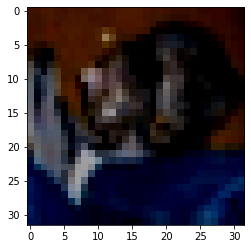

Annotation label: cat
Predicted label: cat


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = (npimg + mean) * std    # unnormalize
    plt.imshow(npimg)
    plt.show()


# get image from dataset
dataiter = iter(testloader)
image, label = dataiter.next()

# make prediction

predicted_scores = pt_model(image)
predicted_label = torch.argmax(predicted_scores)
imshow(image[0])
print(f'Annotation label: {classes[label[0].item()]}')
print(f'Predicted label: {classes[predicted_label.item()]}') 


### Define Accuracy metric

Before starting converting model to OpenVINO, let's verify its accuracy. We will use [accuracy](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html#accuracy) metric from [torchmetrics](https://torchmetrics.readthedocs.io/en/latest/) for that

In [11]:
from torchmetrics import Accuracy
from tqdm import tqdm
accuracy_metric = Accuracy(top_k=1)

with torch.no_grad():
    for (img, lbl) in tqdm(testloader):
        prediction_scores = pt_model(img)
        accuracy_metric.update(predicted_scores, lbl)

print(f'Accuracy model on {len(testloader)} images {accuracy_metric.compute()}')

100%|██████████| 10000/10000 [02:31<00:00, 65.92it/s]

Accuracy model on 10000 images 0.10000000149011612


## Export model to ONNX\* format

OpenVINO supports PyTorch\* through export to the ONNX\* format. We will use `torch.onnx.export` function for obtaining ONNX, 
you can find more info about it in [PyTorch documentation](https://pytorch.org/docs/stable/onnx.html). 
We need provide model object, input data for model tracing (we will use the same image, which we use during model inference validation) 
and path for model saving. 
Optioanally, we can provide target onnx opset for conversion and other parameters specified in documentation (e.g. input and output names or dynamic shapes)

In [12]:
import onnx
torch.onnx.export(pt_model, image, 'mobilenet_v2_cifar.onnx', opset_version=11)
# Load the ONNX model
onnx_model = onnx.load("mobilenet_v2_cifar.onnx")

# Check that the model is well formed
onnx.checker.check_model(onnx_model)

## Convert ONNX Model to OpenVINO Intermideate Representation
While ONNX models are directly supported by OpenVINO™, it can be useful to convert them to IR format to take advantage of advanced OpenVINO optimization tools and features.
`mo.convert' function can be used for converting model using OpenVINO Model Optimizer capabilities. 
It returns of instance OpenVINO Model class, which is ready to use in python interface and can be serialized to IR.

In [13]:
from openvino.tools import mo
from openvino.runtime import serialize, Core

model = mo.convert(input_model='mobilenet_v2_cifar.onnx')
# serialize model for saving IR
serialize(model, 'mobilenet_v2.xml')

## Validate converted model

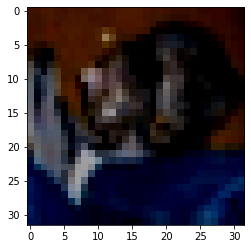

Predicted label: cat, score 5.179418563842773
Annotation label: cat


In [18]:
import numpy as np
core = Core()

compiled_model = core.compile_model(model, 'CPU')
output_tensor = compiled_model.outputs[0]

inference_result = compiled_model(image.numpy())[output_tensor]
pred_label = int(np.argmax(inference_result, axis=1))
pred_score = inference_result[0, pred_label]
imshow(image[0])
print(f'Predicted label: {classes[pred_label]}, score {pred_score}')
print(f'Annotation label: {classes[label[0].item()]}')

In [19]:
accuracy_metric.reset()
for (img, lbl) in tqdm(testloader):
    prediction_scores = torch.from_numpy(compiled_model(img.numpy())[output_tensor])
    accuracy_metric.update(predicted_scores, lbl)

print(f'Accuracy model on {len(testloader)} images {accuracy_metric.compute()}')

100%|██████████| 10000/10000 [00:28<00:00, 356.31it/s]

Accuracy model on 10000 images 0.10000000149011612


## Optimize model using NNCF Posttrainging Quantization API


In [20]:
from nncf import ptq

# Define the transformation method. This method should
# take a data item from the data source and transform it
# into the model expected input.
def transform_fn(data_item):
    images, _ = data_item
    return images.numpy()

calibration_dataset = ptq.create_dataloader(testset, transform_fn)

ImportError: cannot import name 'ptq' from 'nncf' (C:\Users\eaidova\AppData\Roaming\Python\Python39\site-packages\nncf\__init__.py)

In [ ]:
quantized_model = ptq.quantize(model, calibration_dataset)

In [ ]:
serialize(quantized_model, 'mobilenet_v2_cifar_int8.xml')

In [ ]:
import numpy as np
core = Core()

compiled_model = core.compile_model(quantized_model, 'CPU')
output_tensor = compiled_model.outputs[0]

inference_result = compiled_model(image.numpy())[output_tensor]

imshow(image)
print(f'Predicted label: {classes[np.argmax(inference_result, axis=1)]}')
print(f'Annotation label: {classes[label[0].item()]}')

In [ ]:
accuracy_metric.reset()
for (img, lbl) in tqdm(testloader):
    prediction_scores = torch.from_numpy(compiled_model(img.numpy())[output_tensor])
    accuracy_metric.update(predicted_scores, lbl)

print(f'Accuracy model on {len(testloader)} images {accuracy_metric.compute()}')